In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

/home/mohammed/anaconda3/envs/scib_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
# target_conditions = ["10X"]
# source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
# print(source_adata.obs['study'])
# print(target_adata.obs['study'])

In [11]:
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs['study'].isin(removed_viallni)].copy()
chosen_source = ['Freytag']
source_adata = adata_villani_removed[adata_villani_removed.obs['study'].isin(chosen_source)].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
source_adata, source_conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 3347 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Freytag'])

In [12]:
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['Sun_sample1_CS',
 'Oetjen_A',
 'Sun_sample4_TC',
 'Oetjen_U',
 '10X',
 'Sun_sample3_TB',
 'Sun_sample2_KC',
 'Oetjen_P']

In [13]:
source_adata.raw = source_adata

In [14]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [15]:
sc.pp.normalize_total(source_adata)

In [16]:
sc.pp.log1p(source_adata)

In [17]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [18]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [19]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [20]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [21]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='ewc',
)

ewc is happening!
 |████----------------| 23.2%  - val_loss: 427.3528544108 - val_recon_loss: 423.4018452962 - val_kl_loss: 6.8713237445 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████----------------| 24.6%  - val_loss: 427.9288431803 - val_recon_loss: 423.8051350911 - val_kl_loss: 6.7601731618 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 101


In [22]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

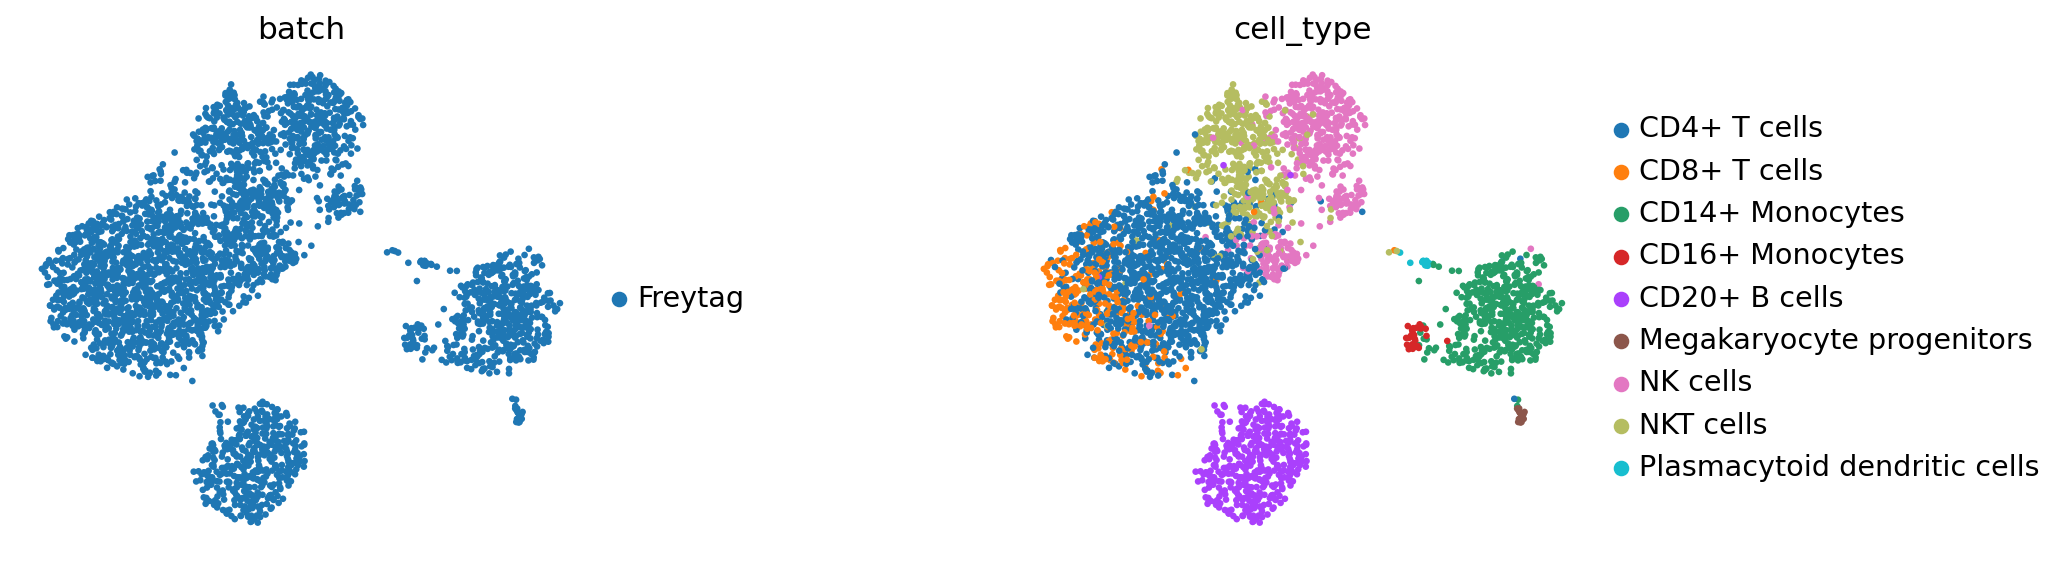

In [23]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [24]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [25]:
for ID, task in enumerate(tasks_list, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID, task)
    task_i = adata_tasks[adata_tasks.obs['batch'].isin([task])]
    task_i = task_i[:, source_adata.var_names]
    new_trvae_EWC_1 = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'ewc',
                                                 model=ref_path)
    new_trvae_EWC_1.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'ewc'
    )
    
    ref_path = 'reference_model_PBMC/'
    new_trvae_EWC_1.save(ref_path, overwrite=True)

1 Sun_sample1_CS
View of AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

ewc is happening!
 |█-------------------| 9.2%  - val_loss: 434.1788635254 - val_recon_loss: 431.4973602295 - val_kl_loss: 11.9177756310 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██------------------| 10.6%  - val_loss: 440.6522674561 - val_recon_loss: 437.6302185059 - val_kl_loss: 11.6232776642 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate 

 |█████---------------| 29.0%  - val_loss: 432.7321624756 - val_recon_loss: 424.5669708252 - val_kl_loss: 11.3405461311 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 123
8 Oetjen_P
View of AnnData object with n_obs × n_vars = 3265 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

ewc is happening!
 |█-------------------| 

In [26]:
target_adata = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 29137 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [27]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [28]:
full_latent = sc.AnnData(new_trvae_EWC_1.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

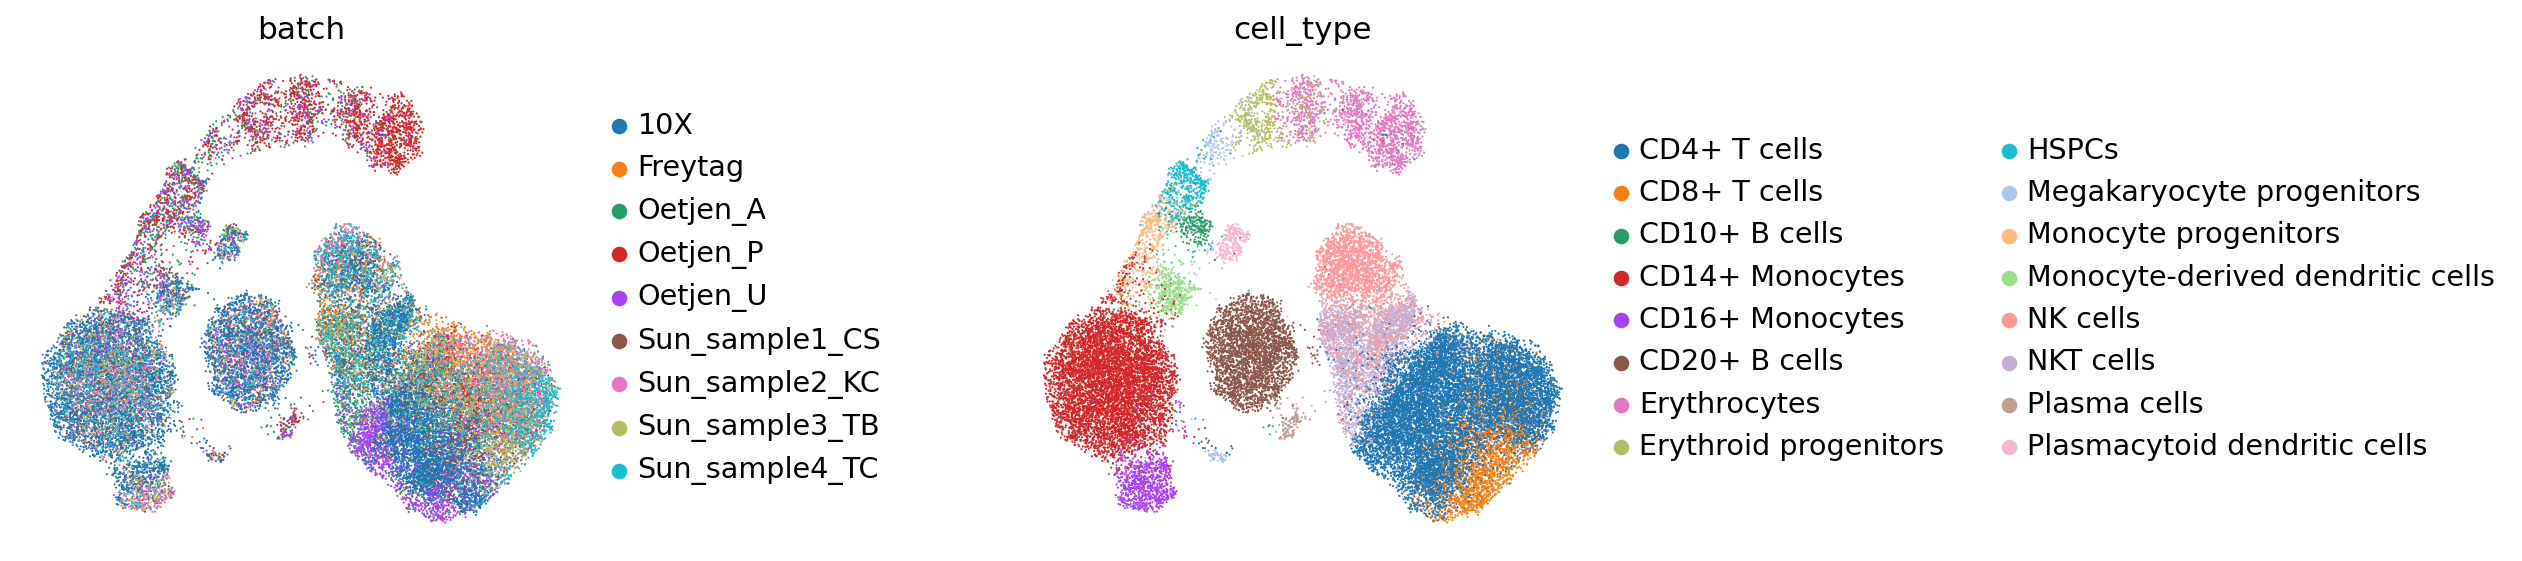

In [29]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [30]:
X_EWC_1= new_trvae_EWC_1.get_latent(adata_full.X, adata_full.obs[condition_key])
%store X_EWC_1

Stored 'X_EWC_1' (ndarray)


In [31]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 02:23:30


In [32]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_justone =scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_justone 




0.6818981697378589

In [33]:
sc.tl.umap(full_latent)
Batch_corr_ASW_justone=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_justone

/tmp/ipykernel_209/828398264.py:2: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Batch_corr_ASW_justone=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.836121
CD14+ Monocytes                           0.874766
CD16+ Monocytes                           0.819265
CD20+ B cells                             0.890915
CD4+ T cells                              0.790378
CD8+ T cells                              0.784824
Erythrocytes                              0.821299
Erythroid progenitors                     0.859485
HSPCs                                     0.778186
Megakaryocyte progenitors                 0.756221
Monocyte progenitors                      0.689542
Monocyte-derived dendritic cells          0.733115
NK cells                                  0.790471
NKT cells                                 0.750520
Plasma cells                              0.819848
Plasmacytoid dendritic cells              0.811909


0.8004291303648847

In [34]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_rehearsal

/tmp/ipykernel_209/403793534.py:1: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')


0.5809974297881126

In [35]:
isolated_labels_justone=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_justone

isolated labels: no more than 3 batches per label
Compute neighbors on rep X_umap
CD10+ B cells: 0.8728179551122194
Compute neighbors on rep X_umap
Erythrocytes: 0.8363220144982831
Compute neighbors on rep X_umap
Erythroid progenitors: 0.8008898776418242
Compute neighbors on rep X_umap
Monocyte progenitors: 0.6974900924702774


0.801879984930651

In [36]:
pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_justone

0.6530575501015305